---
title: "Polars crashcourse (part 1)"
date: "08/10/2023"
author: 
    name: "Rodrigo Zepeda-Tello"
title-block-banner: true
toc: true
number-sections: true
format: 
  html:
    fontsize: 1.1em
    code-fold: false
    code-tools: true
    page-layout: full
    body-width: 1200px
jupyter: python3
---

::: {.callout-important title="Notebook"}
You can download this notebook [from Github](https://github.com/RodrigoZepeda/polars_tutorial/blob/main/basic_polars.ipynb)
:::

# Why polars?

There are three characteristics which, from my perspective, make `polars` a pretty cool library:

1. **Allows for data larger than RAM**: It helps manipulate datasets that are larger than `RAM` memory. This means that you can manipulate any data as long as it fits your hard-drive.

2. **Fast** A [quick comparison of `polars` vs `pandas`](https://www.datacamp.com/tutorial/high-performance-data-manipulation-in-python-pandas2-vs-polars) shows that `polars` is faster from [2x up to 46x times faster than `pandas`](https://www.pola.rs/benchmarks.html).

   a. One of the key reasons polars is faster is that it allows for `parallel` computation out-of-the -box.
   
   b. `Polars` allows the user to perform `lazy` evaluations (to be explained later) and thus optimizes queries.

You can get more info about `polars` [at their website](https://www.pola.rs/). 


# Preparing for the tutorial

## Installation 

### From pip

If you are using `pip` you can install via: 
```bash
pip install polars[all]
```

### From conda

If you are using `conda`, first activate your environment and then:
```bash
conda install -c conda-forge -y polars numpy pyarrow xlsx2csv pandas
```

If you are using Windows you might also need to install the `timezone` package.


## Data

For the purpose of the tutorial I'm using three different databases.

1. **covidmx.parquet** Mexico's COVID-19 cases open dataset. This database contains millions of registries that cannot be processed in using RAM memory only. The original data has been downloaded from [Mexico's Health Ministry](https://www.gob.mx/salud/documentos/datos-abiertos-152127). However, for the purpose of this tutorial I've already pre-formatted the data from the ministry.

2. **inegi_population.csv** Mexico's population by state, municipality and locality according to 2020's census. Data comes from Mexico's Institute of Statistics and Geography (INEGI). 

3. **penguins.csv** The classical [`palmerpenguins`](https://allisonhorst.github.io/palmerpenguins/) dataset. Contains information of penguins in Antartida collected from the Palmer Station. 

::: {.callout-important title="Data"}
Download the data from the [Open Science Framework](https://www.doi.org/10.17605/OSF.IO/B5U7K) and save it into your working directory.
:::



## Additional modules

Some of the modules we are using for this tutorial are:

1. **os** For setting file paths, directories and other operating-system dependent functions.
   
2. **polars** Basic for the tutorial!
   
3. **pandas** To transform the data so that the jupyter notebook and the seaborn plots can use them
      
4. **numpy** For special numeric functions


In [1]:
## Loading modules
import os
import polars as pl
import pandas as pd
import seaborn as sns
import numpy as np

# Reading data

## Basic reading

Data can be read from `csv` files (`read_csv`), `parquet` files[^1] (`read_parquet`), `Excel` files (`read_excel`) and databases from other sources such as `SQL` (`read_database`) and Delta Lakes (`read_delta`). See [the documentation](https://pola-rs.github.io/polars/py-polars/html/reference/io.html) for more database-input options. 

[^1]: Text files optimized for columnar data

One can read the penguins `csv` file:


In [2]:
penguins = pl.read_csv("penguins.csv", null_values = "NA") #Missing values in the csv are represented as "NA"

A quick description of the variables can be obtained with `glimpse`:

In [3]:
penguins.glimpse()

Rows: 344
Columns: 8
$ species           <str> Adelie, Adelie, Adelie, Adelie, Adelie, Adelie, Adelie, Adelie, Adelie, Adelie
$ island            <str> Torgersen, Torgersen, Torgersen, Torgersen, Torgersen, Torgersen, Torgersen, Torgersen, Torgersen, Torgersen
$ bill_length_mm    <f64> 39.1, 39.5, 40.3, None, 36.7, 39.3, 38.9, 39.2, 34.1, 42.0
$ bill_depth_mm     <f64> 18.7, 17.4, 18.0, None, 19.3, 20.6, 17.8, 19.6, 18.1, 20.2
$ flipper_length_mm <i64> 181, 186, 195, None, 193, 190, 181, 195, 193, 190
$ body_mass_g       <i64> 3750, 3800, 3250, None, 3450, 3650, 3625, 4675, 3475, 4250
$ sex               <str> male, female, female, None, female, male, female, male, None, None
$ year              <i64> 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007



One can obtain descriptors for the number of rows and number of columns with the `shape` attribute:

In [4]:
penguins.shape

(344, 8)

Equivalent attributes are the `width` (number of columns) and `height` (number of rows)

In [5]:
print("There are %d columns," % penguins.width)
print("and %d rows." % penguins.height)

There are 8 columns,
and 344 rows.


One can also take a look at the first `n=7` rows with `head`:

In [6]:
penguins.head(n=7)

species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
str,str,f64,f64,i64,i64,str,i64
"""Adelie""","""Torgersen""",39.1,18.7,181,3750,"""male""",2007
"""Adelie""","""Torgersen""",39.5,17.4,186,3800,"""female""",2007
"""Adelie""","""Torgersen""",40.3,18.0,195,3250,"""female""",2007
"""Adelie""","""Torgersen""",null,null,null,null,null,2007
"""Adelie""","""Torgersen""",36.7,19.3,193,3450,"""female""",2007
"""Adelie""","""Torgersen""",39.3,20.6,190,3650,"""male""",2007
"""Adelie""","""Torgersen""",38.9,17.8,181,3625,"""female""",2007


The last `n=3` rows of the dataset can be displayed with `tail`:

In [7]:
penguins.tail(n=3)

species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
str,str,f64,f64,i64,i64,str,i64
"""Chinstrap""","""Dream""",49.6,18.2,193,3775,"""male""",2009
"""Chinstrap""","""Dream""",50.8,19.0,210,4100,"""male""",2009
"""Chinstrap""","""Dream""",50.2,18.7,198,3775,"""female""",2009


By default, jupyter notebooks only allow us to display a certain amount of rows (`display.max_rows`), columns (`display.max_columns`) and with a certain width (`display.max_colwidth`). This can be changed globally by putting `pd.option_context` at the start of the script or just for one print with a `with` (which creates a [context](https://book.pythontips.com/en/latest/context_managers.html)). As jupyter is designed for `pandas` one needs to convert the polars `DataFrame` into a `pandas` one with `to_pandas()`. For example, here we are only showing the first `3` columns (including the row number) and `12` rows: 

In [8]:
with pd.option_context('display.max_rows', 12, 'display.max_columns', 3,'display.max_colwidth', None):
    display(penguins.to_pandas().head(n=12)) #Notice that head must be specified here

,species,...,year
0,Adelie,...,2007
1,Adelie,...,2007
2,Adelie,...,2007
3,Adelie,...,2007
4,Adelie,...,2007
5,Adelie,...,2007
6,Adelie,...,2007
7,Adelie,...,2007
8,Adelie,...,2007
9,Adelie,...,2007


The `sample` command obtains a random sample (without replacement) of the rows of size `n` and keeps it. This command is ideal for debugging `polars` programs as it allows the user to create a smaller database of which one can keep a track of. For example, the following obtains a random sample of size `9` of the data: 

In [9]:
penguins.sample(n = 9)

species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
str,str,f64,f64,i64,i64,str,i64
"""Adelie""","""Biscoe""",37.6,19.1,194,3750,"""male""",2008
"""Gentoo""","""Biscoe""",45.0,15.4,220,5050,"""male""",2008
"""Adelie""","""Biscoe""",36.5,16.6,181,2850,"""female""",2008
"""Gentoo""","""Biscoe""",52.2,17.1,228,5400,"""male""",2009
"""Adelie""","""Biscoe""",38.6,17.2,199,3750,"""female""",2009
"""Chinstrap""","""Dream""",49.0,19.5,210,3950,"""male""",2008
"""Adelie""","""Dream""",39.5,16.7,178,3250,"""female""",2007
"""Gentoo""","""Biscoe""",49.6,16.0,225,5700,"""male""",2008
"""Chinstrap""","""Dream""",49.6,18.2,193,3775,"""male""",2009


To obtain an array of the column names one can do:

In [10]:
penguins.columns

['species',
 'island',
 'bill_length_mm',
 'bill_depth_mm',
 'flipper_length_mm',
 'body_mass_g',
 'sex',
 'year']

## Advanced reading (scanning)

Larger datasets benefit from `scanning`. When a file is `scanned` it is not read. `polars` only registers that it `will`read it. To actually read it you need to perform a `collect` after a scan. This is useful as `polars` optimizes all the queries you produce into the scan so that when you `collect` you obtain a `faster` result than performing the operations one by one. 

Let's see an example by reading the `covidmx` dataset and removing all rows except for those ones that occured in Mexico City which corresponds to `ENTIDAD_UM == "09"`. 

In [11]:
%timeit -n1 -r1 pl.read_parquet("covidmx.parquet").filter(pl.col("ENTIDAD_UM") == "09")

20.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


The previous line `reads` the complete file _and then_  filters by ensuring to keep only the values where the column `ENTIDAD_UM` equals `"09"`. If we use `scan` its way faster as it will collapses the `scan` and the `filter` into one operation and reads only the columns that have a `09` value

In [12]:
%timeit -n1 -r1 pl.scan_parquet("covidmx.parquet").filter(pl.col("ENTIDAD_UM") == "09").collect()

9.13 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


This idea of not conducting all operations till all the queries are given is called **[lazy evaluation](https://en.wikipedia.org/wiki/Lazy_evaluation)** and is one of the keys for `polars`' speed. 

## Exercise

1. Read the `inegi_population.csv` file,
2. Obtain a random sample of `n = 50` rows,
3. Display the complete random sample (all rows and columns) in the jupyter notebook.

# Thinking polars

By design, `polars` data should be in a [tidy](https://doi.org/10.18637/jss.v059.i10) format with rows corresponding to observations and columns corresponding to variables measured from those observations.

![Image of a tidy dataframe showing that columns are variables and rows observations](df_images/column_row_format.svg){width=80%}

Polars is optimized, by design, for columnar data; in particular for its storage. Let's talk about it for a second. 

## SIMD

Let's think of the data for a second. Consider the first five entries of the following subset of the data:

In [13]:
penguins.select(pl.col("bill_length_mm","sex","year")).head()

bill_length_mm,sex,year
f64,str,i64
39.1,"""male""",2007
39.5,"""female""",2007
40.3,"""female""",2007
null,null,2007
36.7,"""female""",2007


The first one, `bill_length_mm` is a float (`f64`) which allows for decimal numbers, the second one, `sex` is a string (`str`) while the last one, `year` is an integer (`i64`). Each of these columns have types (`dtypes` in Python) that allow for different operations. For example, one can sum `+1` to both `bill_length_mm` and `year` but not to `sex`. 

The traditional way to represents data in memory is rowwise which means that the first entry of the float `bill_length_mm` row is next-to (in memory) the string `sex` whose memory address is next to the integer `year`. That means that performing operations in one column (say summing `+1` to year) involves jumping through different memory addresses. 

![Image of a `DataFrame` being stored into memory with two different formats rowwise and columnwise](df_images/dataframe_storage.svg){width=50%}

The columnar format of data stores one column in contiguous memory addresses, then the next column and then the next one. Modern processors are equipped with a gizmo called [**single instruction, multiple data (SIMD)**](https://en.wikipedia.org/wiki/Single_instruction,_multiple_data). SIMD allows for instructions to be performed in memory blocks without specifying the specific address of each member of the block. Thus, storing the columns next to each other generates memory blocks into which SIMD can be applied. 

While, for summing `+1` in the classical `rowwise` data storage one has to go specifying the memory address of the first year, then the address of the second and so on; in the `columar` approach one has only to specify the year memory block. 


## Why should I care?

Polars is designed with the columnar format in mind. That means that to conduct operations in your `DataFrame` one has to think the operations as operations **for the whole column**. This doesn't mean that `rowwise` operations cannot be done. However, `rowwise` operations (as well as `for` loops) are usually suboptimal for `polars` `DataFrames`.  

# DataFrame expressions

In this section, we discuss several transformations one can apply into the `DataFrame`. 

## How to keep/remove stuff

### Select

![`select` chooses which columns to keep or drop](df_images/select.svg){width=75%}

The `select` command allows users to choose which columns to keep. This can be done by specifying the columns:

In [14]:
penguins.select(pl.col("sex","species")).head()

sex,species
str,str
"""male""","""Adelie"""
"""female""","""Adelie"""
"""female""","""Adelie"""
null,"""Adelie"""
"""female""","""Adelie"""


::: {.callout-tip title="Format"}
Code is usually formatted rowwise to avoid run-ons so that each instruction has its row
:::


In [15]:
(penguins
 .select(pl.col("sex","species"))
 .head())

sex,species
str,str
"""male""","""Adelie"""
"""female""","""Adelie"""
"""female""","""Adelie"""
null,"""Adelie"""
"""female""","""Adelie"""


One can select all columns with `.all`:

In [16]:
(penguins
 .select(pl.all())
 .head())

species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
str,str,f64,f64,i64,i64,str,i64
"""Adelie""","""Torgersen""",39.1,18.7,181,3750,"""male""",2007
"""Adelie""","""Torgersen""",39.5,17.4,186,3800,"""female""",2007
"""Adelie""","""Torgersen""",40.3,18.0,195,3250,"""female""",2007
"""Adelie""","""Torgersen""",null,null,null,null,null,2007
"""Adelie""","""Torgersen""",36.7,19.3,193,3450,"""female""",2007


The `all` command can be combined with the `exclude` to remove specific columns:

In [17]:
(penguins
 .select(pl.all().exclude("island"))
 .head())

species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
str,f64,f64,i64,i64,str,i64
"""Adelie""",39.1,18.7,181,3750,"""male""",2007
"""Adelie""",39.5,17.4,186,3800,"""female""",2007
"""Adelie""",40.3,18.0,195,3250,"""female""",2007
"""Adelie""",null,null,null,null,null,2007
"""Adelie""",36.7,19.3,193,3450,"""female""",2007


The previous code is equivalent to using the `drop` function. Note that by design `drop` doesn't use `pl.col` while `select` does. 

In [18]:
(penguins
 .drop("island")
 .head())

species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
str,f64,f64,i64,i64,str,i64
"""Adelie""",39.1,18.7,181,3750,"""male""",2007
"""Adelie""",39.5,17.4,186,3800,"""female""",2007
"""Adelie""",40.3,18.0,195,3250,"""female""",2007
"""Adelie""",null,null,null,null,null,2007
"""Adelie""",36.7,19.3,193,3450,"""female""",2007


[Regular expressions](https://learn.microsoft.com/en-us/dotnet/standard/base-types/regular-expression-language-quick-reference) can be used to select or exclude specific columns matching the expression. For example, to keep those that end up in `mm`:

In [19]:
import polars.selectors as cs

(penguins
 .select(cs.matches("_mm"))
 .head())

bill_length_mm,bill_depth_mm,flipper_length_mm
f64,f64,i64
39.1,18.7,181
39.5,17.4,186
40.3,18.0,195
null,null,null
36.7,19.3,193


To exclude them one needs to negate the operation with `~`:


In [20]:
(penguins
 .select(~cs.matches("_mm"))
 .head())

species,island,body_mass_g,sex,year
str,str,i64,str,i64
"""Adelie""","""Torgersen""",3750,"""male""",2007
"""Adelie""","""Torgersen""",3800,"""female""",2007
"""Adelie""","""Torgersen""",3250,"""female""",2007
"""Adelie""","""Torgersen""",null,null,2007
"""Adelie""","""Torgersen""",3450,"""female""",2007


Boolean operations can be applied inside a `select` thus allowing to apply an **and**

In [21]:
(penguins
 .select(cs.matches("_mm") & cs.matches("length"))
 .head())

bill_length_mm,flipper_length_mm
f64,i64
39.1,181
39.5,186
40.3,195
null,null
36.7,193


or an **or**

In [22]:
(penguins
 .select(cs.matches("_mm") | cs.matches("island"))
 .head())

bill_length_mm,bill_depth_mm,flipper_length_mm,island
f64,f64,i64,str
39.1,18.7,181,"""Torgersen"""
39.5,17.4,186,"""Torgersen"""
40.3,18.0,195,"""Torgersen"""
null,null,null,"""Torgersen"""
36.7,19.3,193,"""Torgersen"""


Columns can also be selected by `dtype` with the `cs.integer()`, `cs.float()`, `cs.numeric()` (float and int), `cs.string()`, `cs.datetime()` as well as [additional selectors](https://pola-rs.github.io/polars/py-polars/html/reference/selectors.html#functions) specified in the manual

In [23]:
#Select all numeric except year. The - acts as a set difference operator.
(penguins
 .select(cs.numeric() - cs.matches("year")) 
 .head())

bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
f64,f64,i64,i64
39.1,18.7,181,3750
39.5,17.4,186,3800
40.3,18.0,195,3250
null,null,null,null
36.7,19.3,193,3450


### Filter

![`filter` chooses which rows to keep or drop](df_images/filter.svg){width=75%}

The `filter` command allows users to choose which rows to keep based upon some `boolean` conditions of the columns. For example one can select those penguins which have a `body_mass_g` greater than `3500`

In [24]:
(penguins
 .filter(pl.col("body_mass_g") >= 3500)
 .head())

species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
str,str,f64,f64,i64,i64,str,i64
"""Adelie""","""Torgersen""",39.1,18.7,181,3750,"""male""",2007
"""Adelie""","""Torgersen""",39.5,17.4,186,3800,"""female""",2007
"""Adelie""","""Torgersen""",39.3,20.6,190,3650,"""male""",2007
"""Adelie""","""Torgersen""",38.9,17.8,181,3625,"""female""",2007
"""Adelie""","""Torgersen""",39.2,19.6,195,4675,"""male""",2007


More complicated filters can be obtained by combining the logical and `&`, or `|`, not `~` and difference `-` operators:

In [25]:
# Keep only Gentoo penguins with bills larger than 50 or flippers smaller than 170. 
(penguins
 .filter((pl.col("species") == "Gentoo") & ((pl.col("flipper_length_mm") < 170) | (pl.col("bill_length_mm") > 50)))
 .head())

species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
str,str,f64,f64,i64,i64,str,i64
"""Gentoo""","""Biscoe""",50.2,14.3,218,5700,"""male""",2007
"""Gentoo""","""Biscoe""",59.6,17.0,230,6050,"""male""",2007
"""Gentoo""","""Biscoe""",50.5,15.9,222,5550,"""male""",2008
"""Gentoo""","""Biscoe""",50.5,15.9,225,5400,"""male""",2008
"""Gentoo""","""Biscoe""",50.1,15.0,225,5000,"""male""",2008


An important filtering command is the `is_in`. This checks whether a column is in an array of values:

In [82]:
(penguins
 .filter(pl.col("species").is_in(["Gentoo","Adelie","Happy Feet"]))
 .sample(n=5))

species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
str,str,f64,f64,i64,i64,str,i64
"""Gentoo""","""Biscoe""",46.7,15.3,219,5200,"""male""",2007
"""Adelie""","""Dream""",36.0,17.8,195,3450,"""female""",2009
"""Gentoo""","""Biscoe""",43.5,15.2,213,4650,"""female""",2009
"""Adelie""","""Torgersen""",38.5,17.9,190,3325,"""female""",2009
"""Gentoo""","""Biscoe""",45.1,14.5,207,5050,"""female""",2007


### Special selectors

#### take_every
returns every `nth` row of the DataFrame

![`take_every` chooses every nth row](df_images/take_every.svg){width=75%}

In [26]:
#Return every third penguin
(penguins
 .take_every(n=3)
 .head())

species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
str,str,f64,f64,i64,i64,str,i64
"""Adelie""","""Torgersen""",39.1,18.7,181,3750,"""male""",2007
"""Adelie""","""Torgersen""",null,null,null,null,null,2007
"""Adelie""","""Torgersen""",38.9,17.8,181,3625,"""female""",2007
"""Adelie""","""Torgersen""",42.0,20.2,190,4250,null,2007
"""Adelie""","""Torgersen""",41.1,17.6,182,3200,"""female""",2007


#### `top_k` 
Returns the first `k` values of a column either by ascending or descending order

![`top_k` chooses every nth row](df_images/top_k.svg){width=75%}

In [27]:
#Return the top 3 fatter penguins:
(penguins
 .top_k(k=5, by = "body_mass_g", descending=True, nulls_last=True) 
 .head())

species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
str,str,f64,f64,i64,i64,str,i64
"""Chinstrap""","""Dream""",46.9,16.6,192,2700,"""female""",2008
"""Adelie""","""Biscoe""",36.5,16.6,181,2850,"""female""",2008
"""Adelie""","""Biscoe""",36.4,17.1,184,2850,"""female""",2008
"""Adelie""","""Torgersen""",38.6,17.0,188,2900,"""female""",2009
"""Adelie""","""Dream""",33.1,16.1,178,2900,"""female""",2008


#### `drop_null` 
Removes all rows that have missing values in a certain column (leave blank for all columns)

![`drop_null` removes all null rows that have null values from a column (or all columns)](df_images/drop_null.svg){width=75%}

In [28]:
#Compare against the take_every 3 previously specified
(penguins
 .take_every(n=3)
 .drop_nulls(["bill_length_mm"])
 .head())

species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
str,str,f64,f64,i64,i64,str,i64
"""Adelie""","""Torgersen""",39.1,18.7,181,3750,"""male""",2007
"""Adelie""","""Torgersen""",38.9,17.8,181,3625,"""female""",2007
"""Adelie""","""Torgersen""",42.0,20.2,190,4250,null,2007
"""Adelie""","""Torgersen""",41.1,17.6,182,3200,"""female""",2007
"""Adelie""","""Torgersen""",36.6,17.8,185,3700,"""female""",2007


### Exercise

Answer the following questions:

1. How many Adelie penguins are from Biscoe Island?
   
2. What is the proportion of male penguins in the database?
   
3. What's the probability that a penguin with flippers less than `200` mm has a body mass greater than 5000?

4. Which species has the penguins with the largest bills?

## How to change columns

### `with_columns`
To change columns one has to select the column with `pl.col` and then apply a function to it within the `with_columns` context. Here is an example where we transform the body mass in grams to kilograms dividing by 1000. 

![`with_columns` operates functions columnwise](df_images/with_cols.svg){width=75%}

In [29]:
(penguins
 .with_columns(
    pl.col("body_mass_g")/1000
 )
 .head()
)

species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
str,str,f64,f64,i64,f64,str,i64
"""Adelie""","""Torgersen""",39.1,18.7,181,3.75,"""male""",2007
"""Adelie""","""Torgersen""",39.5,17.4,186,3.8,"""female""",2007
"""Adelie""","""Torgersen""",40.3,18.0,195,3.25,"""female""",2007
"""Adelie""","""Torgersen""",null,null,null,null,null,2007
"""Adelie""","""Torgersen""",36.7,19.3,193,3.45,"""female""",2007


To avoid overwritting columns we can save the new column using `alias`

In [30]:
(penguins
 .with_columns(
    (pl.col("body_mass_g")/1000).alias("body_mass_kg")
 )
 .head()
)

species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year,body_mass_kg
str,str,f64,f64,i64,i64,str,i64,f64
"""Adelie""","""Torgersen""",39.1,18.7,181,3750,"""male""",2007,3.75
"""Adelie""","""Torgersen""",39.5,17.4,186,3800,"""female""",2007,3.8
"""Adelie""","""Torgersen""",40.3,18.0,195,3250,"""female""",2007,3.25
"""Adelie""","""Torgersen""",null,null,null,null,null,2007,null
"""Adelie""","""Torgersen""",36.7,19.3,193,3450,"""female""",2007,3.45


::: {.callout-tip title="Format"}
In general, columns can be modify within a `context`. For the purpose of the tutorial we'll be using the `with_columns` context. However, this is not the only one and advanced users can take advantage of the `select` context to overwrite columns. 
:::

Numpy's `ufuncs` (special type of numpy functions) can be applied to each column. See [here](https://numpy.org/doc/stable/reference/ufuncs.html#available-ufuncs) for a list of all of the possible functions

In [31]:
(penguins
 .with_columns(
    (np.log(pl.col("bill_depth_mm"))).alias("bill_depth_log") #Set name with alias
 )
 .head()
)

/usr/local/Caskroom/miniconda/base/envs/polars tutorial/lib/python3.10/site-packages/polars/series/series.py:1114: RuntimeWarning: divide by zero encountered in log
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year,bill_depth_log
str,str,f64,f64,i64,i64,str,i64,f64
"""Adelie""","""Torgersen""",39.1,18.7,181,3750,"""male""",2007,2.928524
"""Adelie""","""Torgersen""",39.5,17.4,186,3800,"""female""",2007,2.85647
"""Adelie""","""Torgersen""",40.3,18.0,195,3250,"""female""",2007,2.890372
"""Adelie""","""Torgersen""",null,null,null,null,null,2007,null
"""Adelie""","""Torgersen""",36.7,19.3,193,3450,"""female""",2007,2.960105


It is also possible to apply a function across different columns using selections. For example transforming all milimiter variables to inches:

In [32]:
to_inches = 0.393701 
(penguins
 .with_columns(
    (cs.ends_with("mm")*to_inches).suffix("_inch")
 )
 .head()
)

species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year,bill_length_mm_inch,bill_depth_mm_inch,flipper_length_mm_inch
str,str,f64,f64,i64,i64,str,i64,f64,f64,f64
"""Adelie""","""Torgersen""",39.1,18.7,181,3750,"""male""",2007,15.393709,7.3622087,71.259881
"""Adelie""","""Torgersen""",39.5,17.4,186,3800,"""female""",2007,15.55119,6.850397,73.228386
"""Adelie""","""Torgersen""",40.3,18.0,195,3250,"""female""",2007,15.86615,7.086618,76.771695
"""Adelie""","""Torgersen""",null,null,null,null,null,2007,null,null,null
"""Adelie""","""Torgersen""",36.7,19.3,193,3450,"""female""",2007,14.448827,7.598429,75.984293


Notice that the `suffix` (as well as `prefix`) add to the column name. More advanced names can be achieved via [`map_alias`](https://pola-rs.github.io/polars/py-polars/html/reference/expressions/api/polars.Expr.map_alias.html#polars.Expr.map_alias) which applies a function to the column names. 

### `lit`

To generate a new constant column one can use the `pl.lit` expression. The `alias` gives a name to the column

![`lit` creates a new column from a constant](df_images/lit.svg){width=75%}

In [33]:
(penguins
 .with_columns(
     pl.lit(13).alias("Unlucky column")
 )
 .head()
)

species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year,Unlucky column
str,str,f64,f64,i64,i64,str,i64,i32
"""Adelie""","""Torgersen""",39.1,18.7,181,3750,"""male""",2007,13
"""Adelie""","""Torgersen""",39.5,17.4,186,3800,"""female""",2007,13
"""Adelie""","""Torgersen""",40.3,18.0,195,3250,"""female""",2007,13
"""Adelie""","""Torgersen""",null,null,null,null,null,2007,13
"""Adelie""","""Torgersen""",36.7,19.3,193,3450,"""female""",2007,13


### `when`, `then`, `otherwise`

![`when`, `then`, `otherwise` apply different functions based upon distinct conditions](df_images/when_then_otherwise.svg){width=75%}

Cases can be handled via the `when`, `then`, `otherwise` triad which work as an `if_else` or a `switch`. The `when` specifies a condition, `then` specifies the necessary operations and `otherwise` works as a default. For example, considering the following problem of classifying penguins as "large" if they are Adelie with mass larger than 4000. And "small" otherwise. This can be coded as follows:




In [34]:
(penguins
 .with_columns(
     pl.when((pl.col("species") == "Adelie") & pl.col("body_mass_g") > 4000)
       .then(pl.lit("Large"))
       .otherwise(pl.lit("Small"))
       .alias("size")
 )
 .head()
)

species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year,size
str,str,f64,f64,i64,i64,str,i64,str
"""Adelie""","""Torgersen""",39.1,18.7,181,3750,"""male""",2007,"""Small"""
"""Adelie""","""Torgersen""",39.5,17.4,186,3800,"""female""",2007,"""Small"""
"""Adelie""","""Torgersen""",40.3,18.0,195,3250,"""female""",2007,"""Small"""
"""Adelie""","""Torgersen""",null,null,null,null,null,2007,"""Small"""
"""Adelie""","""Torgersen""",36.7,19.3,193,3450,"""female""",2007,"""Small"""


Multiple `when` can be concatenated. For example to classify the `size` as large if:

+ **Large** if species is Adelie  and body mass is larger than 4000
  
+ **Medium**  if species is Adelie  and body mass is between 3000 and 4000

+ **Small**  if species is Adelie  and body mass is lower than 3000
  
+ **Unclassified** if species is not Adelie

In [35]:
(penguins
 .with_columns(
     pl.when((pl.col("species") == "Adelie") & (pl.col("body_mass_g") > 4000))
       .then(pl.lit("Large"))
       .when((pl.col("species") == "Adelie") & (pl.col("body_mass_g") >= 3000) & (pl.col("body_mass_g") <= 4000))
       .then(pl.lit("Medium"))
       .when((pl.col("species") == "Adelie") & (pl.col("body_mass_g") < 3000))
       .then(pl.lit("Small"))
       .otherwise(pl.lit("Unclassified"))
       .alias("size")
 )
 .head()
)

species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year,size
str,str,f64,f64,i64,i64,str,i64,str
"""Adelie""","""Torgersen""",39.1,18.7,181,3750,"""male""",2007,"""Medium"""
"""Adelie""","""Torgersen""",39.5,17.4,186,3800,"""female""",2007,"""Medium"""
"""Adelie""","""Torgersen""",40.3,18.0,195,3250,"""female""",2007,"""Medium"""
"""Adelie""","""Torgersen""",null,null,null,null,null,2007,"""Unclassified"""
"""Adelie""","""Torgersen""",36.7,19.3,193,3450,"""female""",2007,"""Medium"""


### `rename`

To rename a column the `rename` function has got your back. You just have to state the `old_name: new_name`

![`rename` changes the name of a column](df_images/rename.svg){width=75%}

In [36]:
(penguins
 .rename({"bill_length_mm": "length_of_the_beak", "bill_depth_mm": "depth_of_the_beak"})
 .head()
)

species,island,length_of_the_beak,depth_of_the_beak,flipper_length_mm,body_mass_g,sex,year
str,str,f64,f64,i64,i64,str,i64
"""Adelie""","""Torgersen""",39.1,18.7,181,3750,"""male""",2007
"""Adelie""","""Torgersen""",39.5,17.4,186,3800,"""female""",2007
"""Adelie""","""Torgersen""",40.3,18.0,195,3250,"""female""",2007
"""Adelie""","""Torgersen""",null,null,null,null,null,2007
"""Adelie""","""Torgersen""",36.7,19.3,193,3450,"""female""",2007


### Additional stuff: `max_horizontal`, `min_horizontal` and `cumsum_horizontal`

These special functions get the maximum, minimum or cummulative sum across several columns. For example, consider the following `DataFrame`:

In [37]:
df = pl.DataFrame({
    "a": [1, 8, 3],
    "b": [4, 5, None],
    "c": [1, 1, 1],
    })
df.with_columns(pl.max_horizontal("a", "b"))

a,b,c,max
i64,i64,i64,i64
1,4,1,4
8,5,1,8
3,null,1,3


### Passing arbitrary functions

Arbitrary functions can be passed into the `with_columns`. One should avoid as much as possible passing arbitrary functions as rowwise functions are not optimized and thus kill polars parallelization (thus making it slower). 

In [91]:
#Function calculates x^2
def slow_square(x):
    return x**2

#This calculates the squared of the bill_length _slowly_
(penguins
 .with_columns(
     pl.col("bill_length_mm").apply(slow_square).alias("bill_length^2")
 )
 .head()
)

/var/folders/42/2kdf45dd1qz5n7kf9lm8ld9r0000gn/T/ipykernel_42184/3456260424.py:8: PolarsInefficientApplyWarning: 
Expr.apply is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
In this case, you can replace your `apply` with the following:
  - pl.col("bill_length_mm").apply(slow_square)
  + pl.col("bill_length_mm") ** 2

  pl.col("bill_length_mm").apply(slow_square).alias("bill_length^2")


species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year,bill_length^2
str,str,f64,f64,i64,i64,str,i64,f64
"""Adelie""","""Torgersen""",39.1,18.7,181,3750,"""male""",2007,1528.81
"""Adelie""","""Torgersen""",39.5,17.4,186,3800,"""female""",2007,1560.25
"""Adelie""","""Torgersen""",40.3,18.0,195,3250,"""female""",2007,1624.09
"""Adelie""","""Torgersen""",null,null,null,null,null,2007,null
"""Adelie""","""Torgersen""",36.7,19.3,193,3450,"""female""",2007,1346.89


### Exercise

1. Create a new column with `body_mass` in pounds.
   
2. Create a new column that assigns the coordinates for each of the islands:

| Island | Coordinates |
|--------|-------------|
| Biscoe | 65°26′S 65°30′W |
| Dream | 64°44′S 64°14′W |
| Torgersen | 64°46′S 64°5′W |

3. **Biscoe** island actually represents an archipelago. Rename the `island` column to `region` instead to better capture this nuance. 

## How to aggregate columns

All datasets can be aggregated with the describe function which counts the number of null observations and obtains some summary statistics

In [38]:
penguins.describe()

describe,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
str,str,str,f64,f64,f64,f64,str,f64
"""count""","""344""","""344""",344.0,344.0,344.0,344.0,"""344""",344.0
"""null_count""","""0""","""0""",2.0,2.0,2.0,2.0,"""11""",0.0
"""mean""",null,null,43.92193,17.15117,200.915205,4201.754386,null,2008.02907
"""std""",null,null,5.459584,1.974793,14.061714,801.954536,null,0.818356
"""min""","""Adelie""","""Biscoe""",32.1,13.1,172.0,2700.0,"""female""",2007.0
"""max""","""Gentoo""","""Torgersen""",59.6,21.5,231.0,6300.0,"""male""",2009.0
"""median""",null,null,44.45,17.3,197.0,4050.0,null,2008.0
"""25%""",null,null,39.2,15.6,190.0,3550.0,null,2007.0
"""75%""",null,null,48.5,18.7,213.0,4750.0,null,2009.0


Each of these statistics corresponds to a function applied to the columns. We can replicate this by using aggregation functions: 

### Aggregation functions

![`Aggregation functions` apply a function $\mathbb{R}^n\to \mathbb{R}$ which collapses all column elements into a single number](df_images/aggregate.svg){width=35%}

The [aggregation functions](https://pola-rs.github.io/polars/py-polars/html/reference/dataframe/aggregation.html) apply a function to summarize column values. Basically it applies a function to the whole column and returns one value (for example the mean). This is different from the `with_columns` as the latter applies a function $\mathbb{R}\to\mathbb{R}$ that returns a value for each element in the column. Meanwhile, aggregation functions collapse all columns into a value

In [49]:
(penguins
 .select("bill_length_mm")
 .mean() #Aggregation function of mean
)

bill_length_mm
f64
43.92193


In [51]:
(penguins
 .select(cs.ends_with("mm"))
 .std() #Aggregation function of standard deviation
)

bill_length_mm,bill_depth_mm,flipper_length_mm
f64,f64,f64
5.459584,1.974793,14.061714


In [52]:
(penguins
 .select(cs.starts_with("bill"))
 .quantile(0.1) #Aggregation function of quantile 0.1
)

bill_length_mm,bill_depth_mm
f64,f64
36.6,14.3


### Grouping

![`groupby` creates a context so that we can aggregate by another column](df_images/groupby.svg){width=35%}

Grouping is one of the most important concepts in data analysis. It allows us to perform an operation on a column based upon the values of another column. For example, one can obtain the mean body mass by sex:

In [56]:
(penguins
 .groupby("sex")
 .agg(
     pl.col("body_mass_g").mean()
))

sex,body_mass_g
str,f64
"""female""",3862.272727
"""male""",4545.684524
null,4005.555556


Grouping supports multiple variables and multiple aggregations via `agg`

In [60]:
(penguins
 .groupby(["sex","species"])
 .agg(
     pl.col("body_mass_g").mean().alias("average"),
     pl.col("body_mass_g").std().alias("standard deviation")
))

sex,species,average,standard deviation
str,str,f64,f64
"""female""","""Adelie""",3368.835616,269.380102
"""male""","""Gentoo""",5484.836066,313.158596
null,"""Adelie""",3540.0,477.166114
"""female""","""Chinstrap""",3527.205882,285.333912
"""male""","""Adelie""",4043.493151,346.811553
"""female""","""Gentoo""",4679.741379,281.578294
"""male""","""Chinstrap""",3938.970588,362.13755
null,"""Gentoo""",4587.5,338.193731


For discrete variables such as `sex` and `species` aggregators also exist such as `count`:

In [64]:
(penguins
 .groupby(["sex","species"])
 .agg(
     pl.count() #Count number of observations
 ))

sex,species,count
str,str,u32
"""male""","""Gentoo""",61
"""male""","""Chinstrap""",34
"""male""","""Adelie""",73
"""female""","""Gentoo""",58
"""female""","""Chinstrap""",34
null,"""Adelie""",6
"""female""","""Adelie""",73
null,"""Gentoo""",5


Multiple of the commands we know can be combined as in the following example which calculates the proportion of females per species

In [75]:
(penguins
 .groupby(["sex","species"])
 .agg(
     pl.count() #Count number of observations
 )
 .with_columns(
     pl.col("count")/pl.col("count").sum()
 )
 .filter(pl.col("sex") == "female")
)

sex,species,count
str,str,f64
"""female""","""Adelie""",0.212209
"""female""","""Gentoo""",0.168605
"""female""","""Chinstrap""",0.098837


### `unique` values

![`unique` returns distinct observations](df_images/unique.svg){width=35%}

An array of unique values for a column or `DataFrame` can be obtained via `unique`:

In [83]:
(penguins
 .select("species")
 .unique()
)

species
str
"""Adelie"""
"""Chinstrap"""
"""Gentoo"""


### Exercise

1. What's the average bill_length of the penguins by island?
2. Is there an island where the distribution of `males` and `females` differs across species?
3. What's the maximum weight reported by a penguin and to which species does it belong?

## Timeseries specific functionality
In this section we'll discuss rolling functions, lagging, datetimes and durations. For that purpose we'll use the `covidmx.parquet` file. 

In [102]:
covidmx = pl.read_parquet("covidmx.parquet")

In [93]:
covidmx.glimpse() #This thing is huge!

Rows: 20172065
Columns: 40
$ FECHA_ACTUALIZACION   <str> 2023-08-08, 2023-08-08, 2023-08-08, 2023-08-08, 2023-08-08, 2023-08-08, 2023-08-08, 2023-08-08, 2023-08-08, 2023-08-08
$ ID_REGISTRO           <str> 0ed066, accf18, 65b38d, a9c809, 5db8d9, 8004ba, 7ced56, e19494, 80989f, e9cf4c
$ ORIGEN                <str> 2, 2, 2, 2, 1, 1, 2, 1, 2, 2
$ SECTOR                <str> 12, 12, 12, 12, 12, 12, 12, 12, 12, 12
$ ENTIDAD_UM            <str> 16, 07, 09, 03, 19, 19, 09, 19, 07, 11
$ SEXO                  <str> 2, 2, 2, 2, 2, 1, 2, 2, 1, 2
$ ENTIDAD_NAC           <str> 16, 07, 09, 03, 19, 19, 08, 28, 07, 11
$ ENTIDAD_RES           <str> 16, 07, 09, 03, 19, 19, 09, 19, 07, 11
$ MUNICIPIO_RES         <str> 041, 078, 009, 003, 046, 006, 009, 025, 078, 031
$ TIPO_PACIENTE         <str> 1, 1, 1, 1, 1, 2, 1, 1, 1, 1
$ FECHA_INGRESO         <str> 2023-03-09, 2023-01-19, 2023-03-09, 2023-03-14, 2023-01-01, 2023-01-01, 2023-03-04, 2023-04-15, 2023-01-19, 2023-03-28
$ FECHA_SINTOMAS        <str> 2023

There are a lot of variables here. However, we'll just keep the following: 

+ **FECHA_INGRESO**: Database registry date (date when the case was registered in the database)
  
+ **EDAD**: Age in years of the person
  
+ **TIPO_PACIENTE** Type of patient 1 = outpatient, 2 = hospitalized
  
+ **FECHA_SINTOMAS** Date of symptom onset of the patient
  
+ **FECHA_DEF** Date of patient's death (9999-99-99 if the person is alive)

We start by keeping only these columns and renaming them:


In [103]:
covidmx = (covidmx
           .select(pl.col("FECHA_INGRESO","EDAD","TIPO_PACIENTE","FECHA_SINTOMAS","FECHA_DEF"))
           .rename({"FECHA_INGRESO": "DATE_OF_REGISTRY", 
                    "EDAD": "AGE",
                    "TIPO_PACIENTE": "PATIENT_TYPE",
                    "FECHA_SINTOMAS": "DATE_OF_SYMPTOM_ONSET",
                    "FECHA_DEF": "DATE_OF_DEATH"}))

In [98]:
covidmx.head()

DATE_OF_REGISTRY,AGE,PATIENT_TYPE,DATE_OF_SYMPTOM_ONSET,DATE_OF_DEATH
str,str,str,str,str
"""2023-03-09""","""28""","""1""","""2023-03-06""","""9999-99-99"""
"""2023-01-19""","""20""","""1""","""2023-01-15""","""9999-99-99"""
"""2023-03-09""","""26""","""1""","""2023-03-07""","""9999-99-99"""
"""2023-03-14""","""47""","""1""","""2023-03-10""","""9999-99-99"""
"""2023-01-01""","""39""","""1""","""2023-01-01""","""9999-99-99"""


## Casting

Notice that in the previous dataset `AGE` was read as a string (`str`) and the dates of registry, symptom onset and death were also read as strings. We can change them to integer (`AGE`) and dates (all other) via casting. 

In [104]:
#Transform age to an integer
covidmx = (covidmx
           .with_columns(
               pl.col("AGE").cast(pl.Int64)
           ))
covidmx.head()

DATE_OF_REGISTRY,AGE,PATIENT_TYPE,DATE_OF_SYMPTOM_ONSET,DATE_OF_DEATH
str,i64,str,str,str
"""2023-03-09""",28,"""1""","""2023-03-06""","""9999-99-99"""
"""2023-01-19""",20,"""1""","""2023-01-15""","""9999-99-99"""
"""2023-03-09""",26,"""1""","""2023-03-07""","""9999-99-99"""
"""2023-03-14""",47,"""1""","""2023-03-10""","""9999-99-99"""
"""2023-01-01""",39,"""1""","""2023-01-01""","""9999-99-99"""


Dates can also be casted by specifying the format. In this case they are year, month, day:

In [111]:
covidmx = (covidmx
 .with_columns(
   cs.starts_with("DATE").str.strptime(pl.Datetime, "%Y-%m-%d", strict=False)
))

covidmx.head()

DATE_OF_REGISTRY,AGE,PATIENT_TYPE,DATE_OF_SYMPTOM_ONSET,DATE_OF_DEATH
datetime[μs],i64,str,datetime[μs],datetime[μs]
2023-03-09 00:00:00,28,"""1""",2023-03-06 00:00:00,null
2023-01-19 00:00:00,20,"""1""",2023-01-15 00:00:00,null
2023-03-09 00:00:00,26,"""1""",2023-03-07 00:00:00,null
2023-03-14 00:00:00,47,"""1""",2023-03-10 00:00:00,null
2023-01-01 00:00:00,39,"""1""",2023-01-01 00:00:00,null


To calculate the difference between the date of symptom onset and the registry we create a new variable of type `duration`:

In [114]:
covidmx = (covidmx
 .with_columns(
   (pl.col("DATE_OF_REGISTRY") - pl.col("DATE_OF_SYMPTOM_ONSET")).alias("TIME_TILL_REGISTRY")
))

covidmx.head()

DATE_OF_REGISTRY,AGE,PATIENT_TYPE,DATE_OF_SYMPTOM_ONSET,DATE_OF_DEATH,TIME_TILL_REGISTRY
datetime[μs],i64,str,datetime[μs],datetime[μs],duration[μs]
2023-03-09 00:00:00,28,"""1""",2023-03-06 00:00:00,null,3d
2023-01-19 00:00:00,20,"""1""",2023-01-15 00:00:00,null,4d
2023-03-09 00:00:00,26,"""1""",2023-03-07 00:00:00,null,2d
2023-03-14 00:00:00,47,"""1""",2023-03-10 00:00:00,null,4d
2023-01-01 00:00:00,39,"""1""",2023-01-01 00:00:00,null,0µs


This variable assigns its own time (notice the miliseconds and the day scales) but can be casted into an integer giving the number of days

In [115]:
covidmx = (covidmx
 .with_columns(
   pl.col("TIME_TILL_REGISTRY").dt.days() #Get days as integer
))

covidmx.head()

## Rolling functions
Let's aggregate the patients by counting the number of patients per date of registry so that we get the number of cases per day

In [118]:
covidmx = (covidmx
 .groupby("DATE_OF_SYMPTOM_ONSET")
 .agg(pl.count())
)

A quick look at the data reveals a lot of noise:

<Axes: xlabel='DATE_OF_SYMPTOM_ONSET', ylabel='count'>

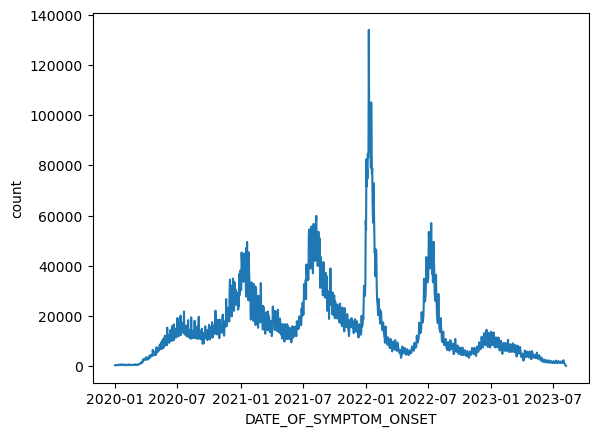

In [124]:
import seaborn as sns
sns.lineplot(x = "DATE_OF_SYMPTOM_ONSET", y = "count", data = covidmx.to_pandas())

Plotting the rolling mean (i.e. the number of cases at day _k_ is estimated as the average of the days from _k - m/2_ to _k + m/2_

In [127]:
covidmx = (covidmx
           .sort("DATE_OF_SYMPTOM_ONSET") #First arrange by date
           .with_columns(
               pl.col("count").rolling_mean(window_size=7).alias("smoothed_count"),
            ))

<Axes: xlabel='DATE_OF_SYMPTOM_ONSET', ylabel='smoothed_count'>

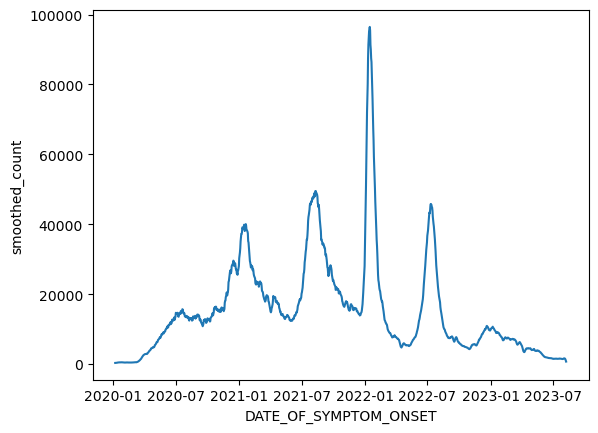

In [128]:
sns.lineplot(x = "DATE_OF_SYMPTOM_ONSET", y = "smoothed_count", data = covidmx.to_pandas())

Another useful grouping mechanism is the `groupby_dynamic` which allows to group by `week`, `year` or other time range from a date. For example, to get all cases in a year we can do the following:

In [129]:
(covidmx
 .groupby_dynamic("DATE_OF_SYMPTOM_ONSET", every="1y")
 .agg(pl.col("count").sum())
)

DATE_OF_SYMPTOM_ONSET,count
datetime[μs],u32
2020-01-01 00:00:00,3868396
2021-01-01 00:00:00,8830345
2022-01-01 00:00:00,6451944
2023-01-01 00:00:00,1021380


### Writing
Once we are done with our data we can save the dataset in `parquet` format which can be read in most programs. 

In [ ]:
covidmx.write_parquet("covid_updated.parquet")

### Exercise

1. The variable `SEXO` encodes `sex` with `1= Male` and `2 = Female`. Use this to decide whether males or females die more (proportionally) of COVID (`CLASIFICACION_FINAL = 5`).
   
2. A common prediction benchmark is to use the mean of the previous period to predict the next one. Calculate the mean of the previous week and use it to predict the next week for all of the observed periods. Use the root mean squared error to estimate how good/bad is this model.
   
3. Does the day of the week seem to influence how much time it takes for an individual to be registered? 

## Where to go from here?

The [Api reference](https://pola-rs.github.io/polars/py-polars/html/reference/expressions/index.html) is a great place to learn about more `polars` functions. That, accompanied with the [book](https://pola-rs.github.io/polars-book/) teaches you all of the `polars` basics you need. Note that this guide hasn't taught you all of polars' functions but the necessary to get started. 

If you still feel you need another guide, I recommend Matt Harrison's tutorial on polars to improve your knowledge

<iframe width="560" height="315" src="https://www.youtube.com/embed/CJ0f45evuME" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>